# Tarea 2 - Análisis de audio con Python y JupyterLab

## 1. Importamos librerias necesarias.

In [23]:
from scipy.io import wavfile
import IPython
import os
import numpy as np
import matplotlib.pyplot as plt

## 2. Definimos los directorios que se van a utilizar.

In [24]:
cwd = os.getcwd()
audio_input_path = os.path.join(cwd, os.path.join('assets', 'audio', 'input'))  # cambiar '_input' por 'examples'
audio_output_path = os.path.join(cwd, os.path.join('assets', 'audio', 'output'))
print(f'Directorio con los audios de entrada: {audio_input_path}')
print(f'Directorio donde guardaremos los audios generados: {audio_output_path}\n')

Directorio con los audios de entrada: /home/ismaeliguess/Workspace/VSCode/SM/audiopy/assets/audio/input
Directorio donde guardaremos los audios generados: /home/ismaeliguess/Workspace/VSCode/SM/audiopy/assets/audio/output



## 3. Cargamos el archivo de audio. Además, mostramos sus graficas.

In [55]:
filename = os.path.join(audio_input_path, 'breaking_bad.wav')
sample_rate, audio_data = wavfile.read(filename)
length = audio_data.shape[0] / sample_rate
total_channels = audio_data.shape[1]

new_mono_data = audio_data.mean(axis=1)  # Column-wise.

wavfile.write(
    filename=os.path.join(audio_output_path, 'breaking_bad_mono.wav'),
    rate=sample_rate,
    data=new_mono_data
)

filename = os.path.join(audio_output_path, 'breaking_bad_mono.wav')
sample_rate, mono_data = wavfile.read(filename)

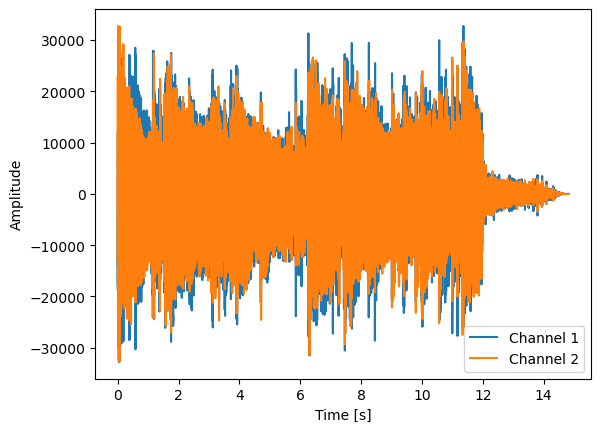

In [56]:
time = np.linspace(0., length, audio_data.shape[0])
for i in range(total_channels):
    plt.plot(time, audio_data[:, i], label=f"Channel {i+1}")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

time = np.linspace(0., length, audio_data.shape[0])
plt.plot(time, mono_data, label=f"Channel 1")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## 4. Aplicamos la Transformada rápida de Fourier y mostramos su grafica.

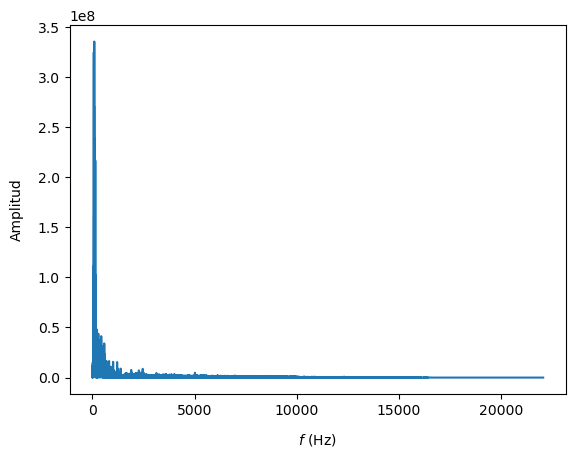

In [57]:
Fs = sample_rate
n = len(mono_data)

ch_Fourier = np.fft.fft(mono_data)

abs_ch_Fourier = np.absolute(ch_Fourier[:n//2])
# Graficamos.
plt.plot(np.linspace(0, Fs/2, n//2), abs_ch_Fourier)
plt.ylabel('Amplitud', labelpad=10)
plt.xlabel('$f$ (Hz)', labelpad=10)
plt.show()

En la gráfica se puede apreciar que en el audio que se estudia, aparecen muchas frecuencias graves y menos agudas.

# 5. Calculamos la energía del espectrograma y una frecuencia de corte.

Epsilon: 0.086
Valor de corte para la energia del espectro: 236953534443.04755
Energía del espectrograma: [2.21634100e+06 5.29904477e+06 8.90418992e+06 ... 2.59248933e+11
 2.59248938e+11 2.59248944e+11]
Mascara: [False False False ...  True  True  True]
Frecuencia de corte f0 (Hz): 8583


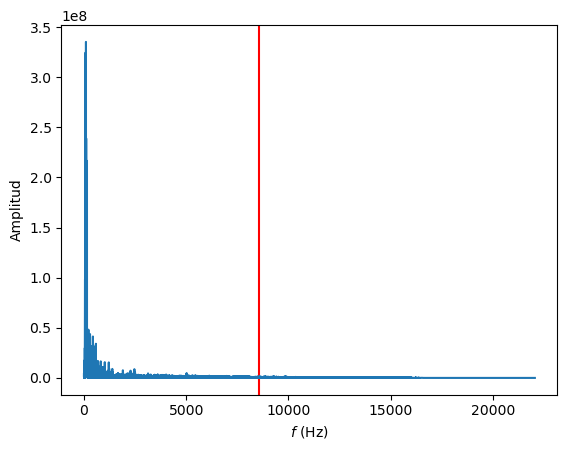

In [59]:
eps = [1e-5, .02, .041, .063, .086, .101, .123]

eps = eps[4]
print(f'Epsilon: {eps}')

thr_spec_energy = (1 - eps) * np.sum(abs_ch_Fourier)
print(f'Valor de corte para la energia del espectro: {thr_spec_energy}')

spec_energy = np.cumsum(abs_ch_Fourier)
print(f"Energía del espectrograma: {spec_energy}")

frequencies_to_remove = thr_spec_energy < spec_energy  
print(f'Mascara: {frequencies_to_remove}')

f0 = (len(frequencies_to_remove) - np.sum(frequencies_to_remove)) * (Fs/2) / (n//2)
print(f'Frecuencia de corte f0 (Hz): {int(f0)}')

plt.axvline(f0, color='r')
plt.plot(np.linspace(0, Fs/2, n//2), abs_ch_Fourier)
plt.ylabel('Amplitud')
plt.xlabel('$f$ (Hz)')
plt.show()

## 6. Aplicamos downsampling a la onda

In [60]:
# Calculamos el factor D de downsampling.
D = int(Fs / f0)
print(f'Factor de downsampling: {D}')

# Obtenemos los nuevos datos (slicing with stride).
new_data = mono_data[::D]

# Definimos el nombre del audio comprimido generado.
wav_compressed_file = "sample_mono_compressed.wav"

# Escribimos los datos a un archivo de tipo wav.
wavfile.write(
    filename=os.path.join(audio_output_path, wav_compressed_file),
    rate=int(Fs/D),
    data=new_data
)

# Cargamos el nuevo archivo.
new_sample_rate, new_audio_data = wavfile.read(filename=os.path.join(audio_output_path, wav_compressed_file))

Factor de downsampling: 5


## 7. Mostramos los espectrogramas

/home/ismaeliguess/anaconda3/envs/audiopy/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


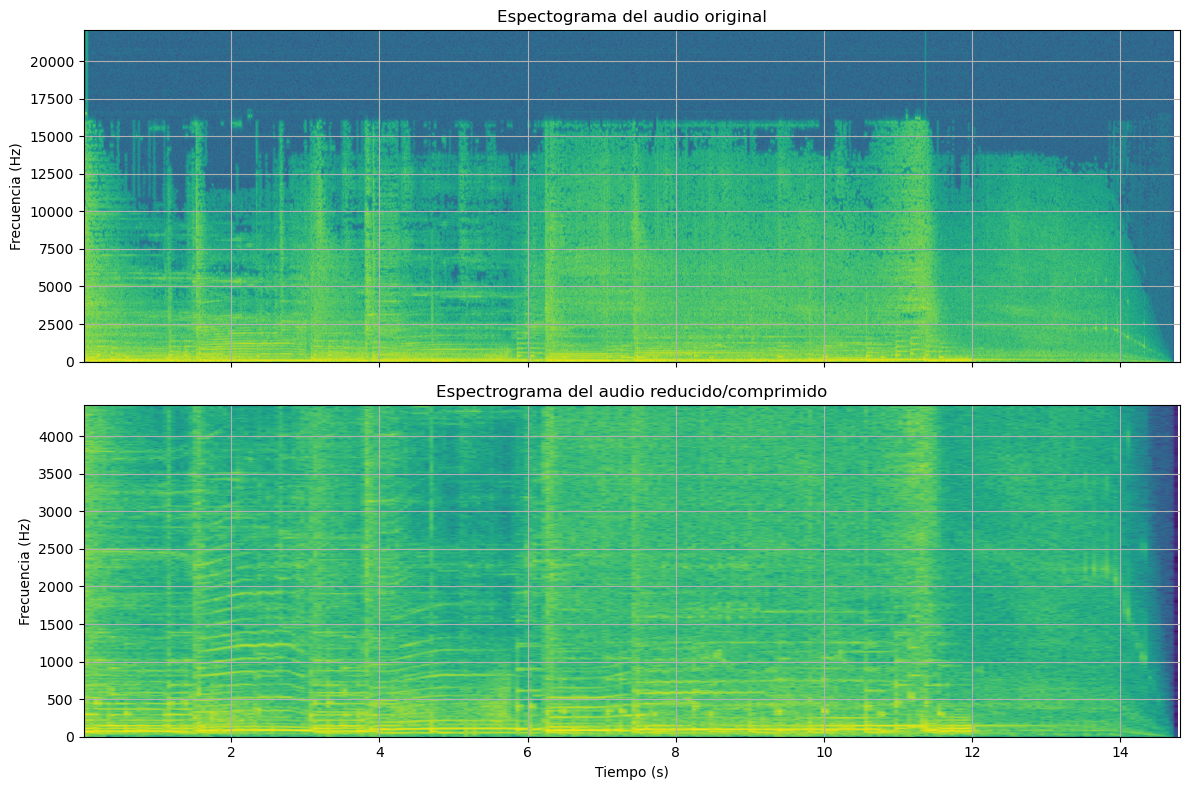

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

Pxx, freqs, bins, im = ax[0].specgram(mono_data, NFFT=1024, Fs=sample_rate, noverlap=512)
ax[0].set_title('Espectograma del audio original')
ax[0].set_ylabel('Frecuencia (Hz)')
ax[0].grid(True)

Pxx, freqs, bins, im = ax[1].specgram(new_audio_data, NFFT=1024, Fs=new_sample_rate, noverlap=512)
ax[1].set_title('Espectrograma del audio reducido/comprimido')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Frecuencia (Hz)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Se puede observar que en el espectrograma del audio comprimido solo se muestran ondas menores de 5000hz.

In [54]:
## 8. Mostramos los tamaños de los diferentes archivos.

In [62]:
!ls -sh assets/audio/output/breaking_bad.wav
!ls -sh assets/audio/output/sample_mono_compressed.wav

2,5M assets/audio/input/breaking_bad.wav
1,0M assets/audio/output/sample_mono_compressed.wav


## Reproducimos los diferentes audios.

In [52]:
IPython.display.Audio(mono_data, rate=sample_rate)

In [51]:
IPython.display.Audio(new_audio_data, rate=new_sample_rate)